In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2
import scipy.signal as signal
from obspy.signal import filter as obsfilt

In [8]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [9]:
sliced_data = data[7500:12500,:]

## Gaussian

In [10]:
def kernel(t):
    res = (1/np.sqrt(2*np.pi))*np.exp(-0.5*t**2)
    return res

In [11]:
radius = 4
size_val = sliced_data.shape[0]
x0 = np.arange(size_val).reshape(-1,1)

weight_matr = np.zeros((size_val,size_val))
incl_list = []
for i, xi in enumerate(x0):
    weight_matr[i,:] = kernel(np.linalg.norm(x0-xi[None,:], axis=1)/radius)

    incl_list.append( np.where(np.abs(weight_matr[i,:])>1e-10)[0])

In [12]:
def gauss_lr(q):
    return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)

In [13]:
smoothed_dat = np.zeros(sliced_data.shape)
for i in tqdm(range(sliced_data.shape[1])):
    smoothed_dat[:,i] = gauss_lr(i)

100%|██████████| 12000/12000 [30:25<00:00,  6.57it/s]


In [14]:
np.save('gaussian_smoothed_small_kernel_channels_7500_12500'+file[:-3]+'.npy', smoothed_dat)

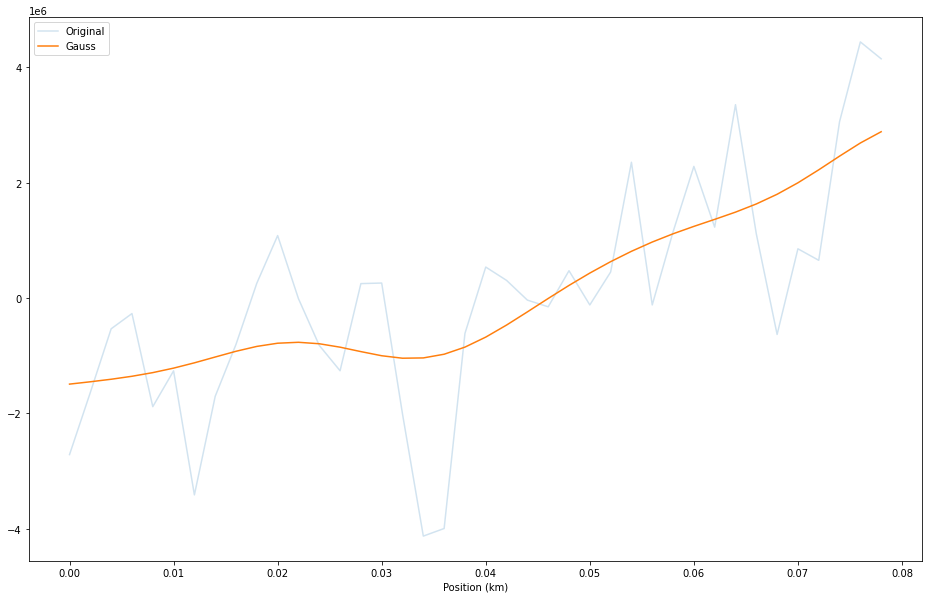

In [21]:
plt.figure(figsize=(16,10))
# plt.plot((2/1000)*np.arange(1000), lp_dat[740,:1000], label="BP Filt")
plt.plot((2/1000)*np.arange(40), data[7500:7540,740], label="Original", alpha=0.2)
plt.plot((2/1000)*np.arange(40), smoothed_dat[:40,740],label="Gauss")
plt.legend()
plt.xlabel("Position (km)")
plt.show()

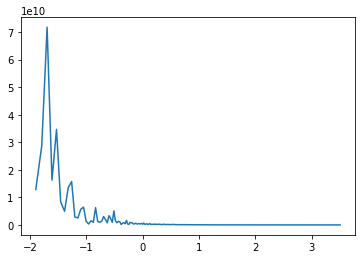

In [41]:
N=12000
yf1 = np.mean(fft(smoothed_dat),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000], 2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [37]:
np.amax(np.log(np.abs(yf1[1:N//2])**2)[8:])

33.6957024127476

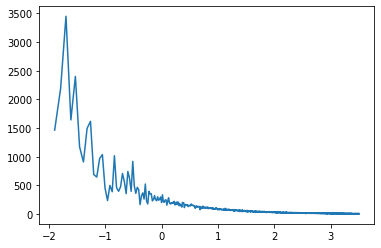

In [31]:
N=12000
yf1 = np.mean(fft(sliced_data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N * np.abs(yf1[1:N//2])[8:-4000])
#plt.xlim(0,0.2)
plt.show()


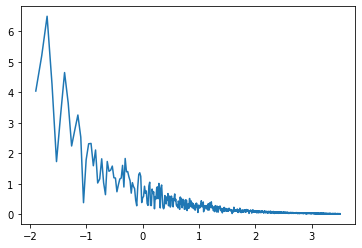

In [24]:
N=12000
yf1 = np.mean(fft(smoothed_dat),axis=0) - np.mean(fft(sliced_data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N * np.abs(yf1[1:N//2])[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [25]:
yf1.size

12000

## Bandpass